# Experiment 01: Airline dataset

In this experiment we use [the airline dataset](http://kt.ijs.si/elena_ikonomovska/data.html) to predict arrival delay. The dataset consists of a large amount of records, containing flight arrival and departure details for all the commercial flights within the USA, from October 1987 to April 2008. Its size is around 116 million records and 5.76 GB of memory.



In [2]:
import os,sys
import numpy as np
import pandas as pd
from lightgbm.sklearn import LGBMRegressor, LGBMClassifier
from xgboost import XGBRegressor
from sklearn.metrics import (confusion_matrix, accuracy_score, roc_auc_score, f1_score, log_loss, precision_score,
                             recall_score)
from libs.loaders import load_airline
from libs.conversion import convert_cols_categorical_to_numeric, convert_related_cols_categorical_to_numeric
from libs.timer import Timer
from libs.utils import get_number_processors
from libs.notebook_memory_management import start_watching_memory
import pkg_resources
import json
import matplotlib.pylab as plt
import warnings
from toolz import curry

print("System version: {}".format(sys.version))
print("XGBoost version: {}".format(pkg_resources.get_distribution('xgboost').version))
print("LightGBM version: {}".format(pkg_resources.get_distribution('lightgbm').version))

%matplotlib inline
warnings.filterwarnings("ignore", category=DeprecationWarning) 

System version: 3.6.1 |Anaconda 4.4.0 (64-bit)| (default, May 11 2017, 13:09:58) 
[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]
XGBoost version: 0.6
LightGBM version: 0.2


The dataset we are going to use in this notebook is huge, therefore we want to monitor the memory consumption. 

In [3]:
start_watching_memory()

In [3] used 12.2734 MiB RAM in 6.22s, total RAM usage 220.41 MiB


# 1) XGBoost vs LightGBM benchmark
In the next section we compare both libraries speed, accuracy and other metrics for the dataset of airline arrival delay. 

### Data loading and management

In [4]:
%%time
df_plane = load_airline()
print(df_plane.shape)

INFO:libs.loaders:MOUNT_POINT not found in environment. Defaulting to /fileshare


(115069017, 14)
CPU times: user 1min 32s, sys: 17.7 s, total: 1min 50s
Wall time: 4min 30s
In [4] used 21994.8516 MiB RAM in 271.08s, total RAM usage 22215.27 MiB


In [5]:
df_plane.head()

,Year,Month,DayofMonth,DayofWeek,CRSDepTime,CRSArrTime,UniqueCarrier,FlightNum,ActualElapsedTime,Origin,Dest,Distance,Diverted,ArrDelay
0,1987,10,1,4,1,556,AA,190,247,SFO,ORD,1846,0,27
1,1987,10,1,4,5,114,EA,57,74,LAX,SFO,337,0,5
2,1987,10,1,4,5,35,HP,351,167,ICT,LAS,987,0,17
3,1987,10,1,4,5,40,DL,251,35,MCO,PBI,142,0,-2
4,1987,10,1,4,8,517,UA,500,208,LAS,ORD,1515,0,17


In [5] used 0.3242 MiB RAM in 0.12s, total RAM usage 22215.59 MiB


The first step is to convert the categorical features to numeric features.

In [7]:
%%time
df_plane_numeric = convert_related_cols_categorical_to_numeric(df_plane, col_list=['Origin','Dest'])
del df_plane

CPU times: user 1min 36s, sys: 13.8 s, total: 1min 50s
Wall time: 1min 52s
In [7] used 5270.3164 MiB RAM in 112.59s, total RAM usage 27485.91 MiB


In [8]:
df_plane_numeric.head()

,Year,Month,DayofMonth,DayofWeek,CRSDepTime,CRSArrTime,UniqueCarrier,FlightNum,ActualElapsedTime,Origin,Dest,Distance,Diverted,ArrDelay
0,1987,10,1,4,1,556,AA,190,247,0,33,1846,0,27
1,1987,10,1,4,5,114,EA,57,74,1,0,337,0,5
2,1987,10,1,4,5,35,HP,351,167,2,4,987,0,17
3,1987,10,1,4,5,40,DL,251,35,3,41,142,0,-2
4,1987,10,1,4,8,517,UA,500,208,4,33,1515,0,17


In [8] used 0.0039 MiB RAM in 0.12s, total RAM usage 27485.91 MiB


In [9]:
%%time
df_plane_numeric = convert_cols_categorical_to_numeric(df_plane_numeric, col_list='UniqueCarrier')

CPU times: user 56.3 s, sys: 10.4 s, total: 1min 6s
Wall time: 1min 7s
In [9] used 13168.8945 MiB RAM in 68.02s, total RAM usage 40654.80 MiB


In [10]:
df_plane_numeric.head()

,Year,Month,DayofMonth,DayofWeek,CRSDepTime,CRSArrTime,UniqueCarrier,FlightNum,ActualElapsedTime,Origin,Dest,Distance,Diverted,ArrDelay
0,1987,10,1,4,1,556,0,190,247,0,33,1846,0,27
1,1987,10,1,4,5,114,1,57,74,1,0,337,0,5
2,1987,10,1,4,5,35,2,351,167,2,4,987,0,17
3,1987,10,1,4,5,40,3,251,35,3,41,142,0,-2
4,1987,10,1,4,8,517,4,500,208,4,33,1515,0,17


In [10] used 0.0078 MiB RAM in 0.12s, total RAM usage 40654.81 MiB


To simplify the pipeline, we are going to set a classification problem where the goal is to classify wheather a flight has arrived delayed or not. For that we need to binarize the variable `ArrDelay`.

If you want to extend this experiment, you can set a regression problem and try to identify the number of minutes of delay a fight has. Both XGBoost and LightGBM have regression classes.

In [11]:
%%time
df_plane_numeric['ArrDelayBinary'] = 1*(df_plane_numeric['ArrDelay'] > 0)

CPU times: user 556 ms, sys: 400 ms, total: 956 ms
Wall time: 955 ms
In [11] used 877.9102 MiB RAM in 1.06s, total RAM usage 41532.72 MiB


In [12]:
df_plane_numeric.head()

,Year,Month,DayofMonth,DayofWeek,CRSDepTime,CRSArrTime,UniqueCarrier,FlightNum,ActualElapsedTime,Origin,Dest,Distance,Diverted,ArrDelay,ArrDelayBinary
0,1987,10,1,4,1,556,0,190,247,0,33,1846,0,27,1
1,1987,10,1,4,5,114,1,57,74,1,0,337,0,5,1
2,1987,10,1,4,5,35,2,351,167,2,4,987,0,17,1
3,1987,10,1,4,5,40,3,251,35,3,41,142,0,-2,0
4,1987,10,1,4,8,517,4,500,208,4,33,1515,0,17,1


In [12] used -5267.4570 MiB RAM in 0.13s, total RAM usage 36265.27 MiB


Once the features are prepared, let's split the dataset into train and test set. We won't use validation for this example (however, you can try to add it).

In [13]:
def split_train_val_test_df(df, val_size=0.2, test_size=0.2):
    train, validate, test = np.split(df.sample(frac=1), 
                                     [int((1-val_size-test_size)*len(df)), int((1-test_size)*len(df))])
    return train, validate, test

In [13] used 0.0000 MiB RAM in 0.10s, total RAM usage 36265.27 MiB


In [14]:
%%time
train, validate, test = split_train_val_test_df(df_plane_numeric, val_size=0, test_size=0.2)
print(train.shape)
print(validate.shape)
print(test.shape)

(92055213, 15)
(0, 15)
(23013804, 15)
CPU times: user 43.9 s, sys: 38.9 s, total: 1min 22s
Wall time: 1min 24s
In [14] used 10518.2578 MiB RAM in 84.82s, total RAM usage 46783.52 MiB


In [15]:
def generate_feables(df):
    X = df[df.columns.difference(['ArrDelay', 'ArrDelayBinary'])]
    y = df['ArrDelayBinary']
    return X,y

In [15] used 0.5703 MiB RAM in 0.10s, total RAM usage 46784.09 MiB


In [16]:
%%time
X_train, y_train = generate_feables(train)
X_val, y_val = generate_feables(validate)
X_test, y_test = generate_feables(test)


CPU times: user 2.14 s, sys: 2.46 s, total: 4.6 s
Wall time: 4.66 s
In [16] used 9131.0234 MiB RAM in 4.76s, total RAM usage 55915.12 MiB


In [17]:
del train, validate, test

In [17] used 0.0000 MiB RAM in 0.10s, total RAM usage 55915.12 MiB


### Training 
Now we are going to create two pipelines, one of XGBoost and one for LightGBM. The technology behind both libraries is different, so it is difficult to compare them in the exact same model setting. XGBoost grows the trees depth-wise and controls model complexity with `max_depth`. Instead, LightGBM uses a leaf-wise algorithm and controls the model complexity by `num_leaves`. As a tradeoff, we use XGBoost with `max_depth=8`, which will have max number leaves of 255, and compare it with LightGBM with `num_leaves=255`. 

In [18]:
results_dict = dict()

In [18] used 0.0000 MiB RAM in 0.10s, total RAM usage 55915.12 MiB


In [19]:
number_processors = get_number_processors()
print(number_processors)

20
In [19] used 0.0000 MiB RAM in 0.10s, total RAM usage 55915.12 MiB


Let's start with the XGBoost classifier.

In [20]:
xgb_clf_pipeline = XGBRegressor(max_depth=8,
                                n_estimators=50,
                                min_child_weight=30,
                                learning_rate=0.1,
                                colsample_bytree=0.80,
                                scale_pos_weight=2,
                                gamma=0.1,
                                reg_lambda=1,
                                subsample=1,
                                n_jobs=number_processors,
                                random_state=77)

In [20] used 0.0039 MiB RAM in 0.20s, total RAM usage 55915.12 MiB


In [21]:
with Timer() as t:
    xgb_clf_pipeline.fit(X_train, y_train)

In [21] used 18443.2852 MiB RAM in 1852.67s, total RAM usage 74358.41 MiB


In [22]:
results_dict['xgb']={
    'train_time': t.interval
}

In [22] used 0.2500 MiB RAM in 0.10s, total RAM usage 74358.66 MiB


Training XGBoost model with leave-wise growth

In [23]:
xgb_hist_clf_pipeline = XGBRegressor(max_depth=0,
                                    n_estimators=50,
                                    min_child_weight=30,
                                    learning_rate=0.1,
                                    colsample_bytree=0.80,
                                    scale_pos_weight=2,
                                    gamma=0.1,
                                    reg_lambda=1,
                                    subsample=1,
                                    max_leaves=255,
                                    grow_policy='lossguide',
                                    tree_method='hist',
                                    n_jobs=number_processors,
                                    random_state=77)

In [23] used 0.0000 MiB RAM in 0.10s, total RAM usage 74358.66 MiB


In [24]:
with Timer() as t:
    xgb_hist_clf_pipeline.fit(X_train, y_train)

In [24] used 23247.5430 MiB RAM in 595.04s, total RAM usage 97606.20 MiB


In [25]:
results_dict['xgb_hist']={
    'train_time': t.interval
}

In [25] used 0.2109 MiB RAM in 0.10s, total RAM usage 97606.41 MiB


Training LightGBM model

In [26]:
lgbm_clf_pipeline = LGBMRegressor(num_leaves=255,
                                  n_estimators=50,
                                  min_child_weight=30,
                                  learning_rate=0.1,
                                  colsample_bytree=0.80,
                                  scale_pos_weight=2,
                                  min_split_gain=0.1,
                                  reg_lambda=1,
                                  subsample=1,
                                  nthread=number_processors,
                                  seed=77)

In [26] used 0.0000 MiB RAM in 0.10s, total RAM usage 97606.41 MiB


In [27]:
with Timer() as t:
    lgbm_clf_pipeline.fit(X_train, y_train)

In [27] used 12295.2539 MiB RAM in 511.70s, total RAM usage 109901.66 MiB


In [29]:
results_dict['lgbm']={
    'train_time': t.interval
}

In [29] used 0.0000 MiB RAM in 0.16s, total RAM usage 109901.85 MiB


As it can be seen in the results, given the specific versions and parameters of both XGBoost and LightGBM and in this specific dataset, LightGBM is faster. 

In general terms, leaf-wise algorithms are more efficient, they converge much faster than depth-wise. However, it may cause over-fitting when the data is small or there are too many leaves.

### Evaluation
Now let's evaluate the model in the test set.

In [30]:
with Timer() as t:
    y_prob_xgb = np.clip(xgb_clf_pipeline.predict(X_test), 0.0001, 0.9999)

In [30] used 175.6758 MiB RAM in 13.46s, total RAM usage 110077.53 MiB


In [31]:
results_dict['xgb']['test_time'] = t.interval

In [31] used -9130.1641 MiB RAM in 0.10s, total RAM usage 100947.36 MiB


In [32]:
with Timer() as t:
    y_prob_xgb_hist = np.clip(xgb_hist_clf_pipeline.predict(X_test), 0.0001, 0.9999)

In [32] used 87.8125 MiB RAM in 15.95s, total RAM usage 101035.18 MiB


In [33]:
results_dict['xgb_hist']['test_time'] = t.interval

In [33] used 0.0000 MiB RAM in 0.10s, total RAM usage 101035.18 MiB


In [34]:
with Timer() as t:
    y_prob_lgbm = np.clip(lgbm_clf_pipeline.predict(X_test), 0.0001, 0.9999)

In [34] used 2458.2109 MiB RAM in 16.61s, total RAM usage 103493.39 MiB


In [35]:
results_dict['lgbm']['test_time'] = t.interval


In [35] used 0.0312 MiB RAM in 0.10s, total RAM usage 103493.42 MiB


### Metrics
We are going to obtain some metrics to evaluate the performance of each of the models.

In [36]:
#https://github.com/miguelgfierro/codebase/blob/master/python/machine_learning/metrics.py
def classification_metrics_binary(y_true, y_pred):
    m_acc = accuracy_score(y_true, y_pred)
    m_f1 = f1_score(y_true, y_pred)
    m_precision = precision_score(y_true, y_pred)
    m_recall = recall_score(y_true, y_pred)
    report = {'Accuracy':m_acc, 'Precision':m_precision, 'Recall':m_recall, 'F1':m_f1}
    return report

In [36] used 0.0000 MiB RAM in 0.10s, total RAM usage 103493.42 MiB


In [37]:
#https://github.com/miguelgfierro/codebase/blob/master/python/machine_learning/metrics.py
def classification_metrics_binary_prob(y_true, y_prob):
    m_auc = roc_auc_score(y_true, y_prob)
    report = {'AUC':m_auc}
    return report

In [37] used 0.0000 MiB RAM in 0.10s, total RAM usage 103493.42 MiB


In [38]:
def binarize_prediction(y, threshold=0.5):
    y_pred = np.where(y > threshold, 1, 0)
    return y_pred

In [38] used 0.0000 MiB RAM in 0.10s, total RAM usage 103493.42 MiB


In [39]:
y_pred_xgb = binarize_prediction(y_prob_xgb)
y_pred_xgb_hist = binarize_prediction(y_prob_xgb_hist)
y_pred_lgbm = binarize_prediction(y_prob_lgbm)


In [39] used 526.6562 MiB RAM in 0.60s, total RAM usage 104020.07 MiB


In [40]:
report_xgb = classification_metrics_binary(y_test, y_pred_xgb)
report2_xgb = classification_metrics_binary_prob(y_test, y_prob_xgb)
report_xgb.update(report2_xgb)

In [40] used 534.1289 MiB RAM in 31.88s, total RAM usage 104554.20 MiB


In [41]:
results_dict['xgb']['performance'] = report_xgb

In [41] used 0.0000 MiB RAM in 0.10s, total RAM usage 104554.20 MiB


In [42]:
report_xgb_hist = classification_metrics_binary(y_test, y_pred_xgb_hist)
report2_xgb_hist = classification_metrics_binary_prob(y_test, y_prob_xgb_hist)
report_xgb_hist.update(report2_xgb_hist)

In [42] used 0.0000 MiB RAM in 27.09s, total RAM usage 104554.20 MiB


In [43]:
results_dict['xgb_hist']['performance'] = report_xgb_hist

In [43] used 0.0000 MiB RAM in 0.10s, total RAM usage 104554.20 MiB


In [44]:
report_lgbm = classification_metrics_binary(y_test, y_pred_lgbm)
report2_lgbm = classification_metrics_binary_prob(y_test, y_prob_lgbm)
report_lgbm.update(report2_lgbm)

In [44] used 0.0000 MiB RAM in 27.60s, total RAM usage 104554.20 MiB


In [45]:
results_dict['lgbm']['performance'] = report_lgbm

In [45] used 0.0000 MiB RAM in 0.10s, total RAM usage 104554.20 MiB


In [46]:
# Results
print(json.dumps(results_dict, indent=4, sort_keys=True))

{
    "lgbm": {
        "performance": {
            "AUC": 0.8087345269327301,
            "Accuracy": 0.735365392005598,
            "F1": 0.693742263725405,
            "Precision": 0.7698017644571464,
            "Recall": 0.63136124169849
        },
        "test_time": 16.278497151011834,
        "train_time": 505.5069723850029
    },
    "xgb": {
        "performance": {
            "AUC": 0.7861648512420553,
            "Accuracy": 0.632291732388092,
            "F1": 0.6988089123079965,
            "Precision": 0.5717217499313083,
            "Recall": 0.8985451545944861
        },
        "test_time": 13.243474364004214,
        "train_time": 1821.469936723006
    },
    "xgb_hist": {
        "performance": {
            "AUC": 0.8078543079265786,
            "Accuracy": 0.6744731118766806,
            "F1": 0.7173539975918762,
            "Precision": 0.6102002842130803,
            "Recall": 0.8701572351164102
        },
        "test_time": 15.677170230002957,
        "tra

The experiment shows a fairly similar performance in both libraries, being LightGBM slightly better.

In [47]:
del xgb_clf_pipeline, xgb_hist_clf_pipeline, lgbm_clf_pipeline, X_train, X_test, X_val

In [47] used -53454.2227 MiB RAM in 1.56s, total RAM usage 48817.42 MiB


# 2) Concept drift
In this section we are trying to find concept drift in the dataset to check if retraining is valuable.

### Data management
We are going to pack the data yearly to try to find concept drift

In [48]:
initial_year = 1987
num_ini = 5

In [48] used 0.0000 MiB RAM in 0.10s, total RAM usage 48817.42 MiB


In [50]:
def generate_subset_by_year(df, year_ini, year_end):
    return df[df['Year'].isin(range(year_ini, year_end))]

In [50] used 0.0625 MiB RAM in 0.10s, total RAM usage 48817.48 MiB


In [51]:
%%time
subset_base = generate_subset_by_year(df_plane_numeric, initial_year, initial_year + num_ini)
print(subset_base.shape)

(16810190, 15)
CPU times: user 1.73 s, sys: 8 ms, total: 1.74 s
Wall time: 1.78 s
In [51] used 0.1367 MiB RAM in 1.88s, total RAM usage 48817.62 MiB


In [53]:
%%time
rest_df = df_plane_numeric.loc[df_plane_numeric.index.difference(subset_base.index)]
print(rest_df.shape)

(98258827, 15)
CPU times: user 1min 14s, sys: 6.2 s, total: 1min 20s
Wall time: 1min 21s
In [53] used 17114.7461 MiB RAM in 81.71s, total RAM usage 65932.62 MiB


### Traininig
Let's see what happens when we train on a subset of data and then evaluate in the data of the following years.

In [54]:
X_train, y_train = generate_feables(subset_base)
del(subset_base)

In [54] used -8867.6094 MiB RAM in 1.05s, total RAM usage 57065.02 MiB


In [55]:
clf = LGBMClassifier(num_leaves=255,
                    n_estimators=100,
                    min_child_weight=30,
                    learning_rate=0.1,
                    subsample=0.80,
                    colsample_bytree=0.80,
                    seed=42)

In [55] used 0.0000 MiB RAM in 0.10s, total RAM usage 57065.02 MiB


In [56]:
%%time
clf.fit(X_train, y_train)

CPU times: user 24min 26s, sys: 23 s, total: 24min 49s
Wall time: 1min 19s


LGBMClassifier(boosting_type='gbdt', colsample_bytree=0.8, learning_rate=0.1,
        max_bin=255, max_depth=-1, min_child_samples=10,
        min_child_weight=30, min_split_gain=0, n_estimators=100,
        nthread=-1, num_leaves=255, objective='binary', reg_alpha=0,
        reg_lambda=0, seed=42, silent=True, subsample=0.8,
        subsample_for_bin=50000, subsample_freq=1)

In [56] used 1676.8320 MiB RAM in 79.21s, total RAM usage 58741.85 MiB


### Prediction

In [57]:
@curry
def predict_accuracy(clf, test_df):
    X_test, y_test = generate_feables(test_df)
    y_pred = clf.predict(X_test)
    return accuracy_score(y_test, y_pred)

In [57] used 0.0000 MiB RAM in 0.10s, total RAM usage 58741.85 MiB


In [58]:
%%time
accuracy_series = rest_df.groupby('Year').apply(predict_accuracy(clf))
print(accuracy_series)

Year
1992    0.755851
1993    0.755262
1994    0.743402
1995    0.730882
1996    0.722218
1997    0.720393
1998    0.705346
1999    0.700259
2000    0.689137
2001    0.673514
2002    0.679002
2003    0.684676
2004    0.679677
2005    0.672613
2006    0.663230
2007    0.651053
2008    0.635933
dtype: float64
CPU times: user 35min 12s, sys: 1min 27s, total: 36min 40s
Wall time: 2min 34s
In [58] used 18055.7109 MiB RAM in 154.14s, total RAM usage 76797.56 MiB


From the results we can observe that the accuracy of the model gets worse as the years pass on.

### Retraining
Now let's see what happens when we retrain and evaluate in the data of the following years.

In [59]:
new_init = 15

In [59] used 0.0000 MiB RAM in 0.10s, total RAM usage 76797.56 MiB


In [66]:
%%time
subset_retrain = generate_subset_by_year(df_plane_numeric, initial_year, initial_year + new_init) 
print(subset_retrain.shape)

(69425349, 15)
CPU times: user 4.96 s, sys: 3.66 s, total: 8.61 s
Wall time: 8.73 s
In [66] used 8474.7227 MiB RAM in 8.84s, total RAM usage 113458.84 MiB


In [61]:
X_train, y_train = generate_feables(subset_retrain)

In [61] used 5193.6953 MiB RAM in 11.50s, total RAM usage 89936.24 MiB


In [62]:
clf_retrain = LGBMClassifier(num_leaves=255,
                            n_estimators=100,
                            min_child_weight=30,
                            learning_rate=0.1,
                            subsample=0.80,
                            colsample_bytree=0.80,
                            seed=42)

In [62] used 0.0000 MiB RAM in 0.10s, total RAM usage 89936.24 MiB


In [63]:
%%time
clf_retrain.fit(X_train, y_train)

CPU times: user 1h 35min 27s, sys: 1min 33s, total: 1h 37min 1s
Wall time: 5min 22s


LGBMClassifier(boosting_type='gbdt', colsample_bytree=0.8, learning_rate=0.1,
        max_bin=255, max_depth=-1, min_child_samples=10,
        min_child_weight=30, min_split_gain=0, n_estimators=100,
        nthread=-1, num_leaves=255, objective='binary', reg_alpha=0,
        reg_lambda=0, seed=42, silent=True, subsample=0.8,
        subsample_for_bin=50000, subsample_freq=1)

In [63] used 7946.2539 MiB RAM in 322.92s, total RAM usage 97882.49 MiB


### Prediction

In [67]:
%%time
rest_df = df_plane_numeric.loc[df_plane_numeric.index.difference(subset_retrain.index)]
print(rest_df.shape)

(45643668, 15)
CPU times: user 31.5 s, sys: 6.83 s, total: 38.4 s
Wall time: 38.8 s
In [67] used -5910.6914 MiB RAM in 38.93s, total RAM usage 107548.15 MiB


In [75]:
%%time
accuracy_retrain = rest_df.groupby('Year').apply(predict_accuracy(clf_retrain))
print(accuracy_retrain)

Year
2002    0.751166
2003    0.749844
2004    0.726010
2005    0.720412
2006    0.707695
2007    0.696212
2008    0.699735
dtype: float64
CPU times: user 16min 10s, sys: 21.8 s, total: 16min 32s
Wall time: 1min 15s
In [75] used 10614.3203 MiB RAM in 75.32s, total RAM usage 82921.84 MiB


### Plot

In [68]:
def plot_metrics(metric1, metric2, legend1=None, legend2=None, x_label=None, y_label=None):
    lists = sorted(metric1.items()) 
    x, y = zip(*lists) 
    fig, ax = plt.subplots()
    ax.plot(x, y, label=legend1, color='#5975a4')
    lists2 = sorted(metric2.items()) 
    x2, y2 = zip(*lists2) 
    ax.plot(x2, y2, label=legend2, color='#5f9e6f')
    legend = ax.legend(loc=0)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    plt.show()
    return ax

In [68] used -22750.0078 MiB RAM in 0.62s, total RAM usage 84798.14 MiB


In [ ]:
# Airline Retrain Results

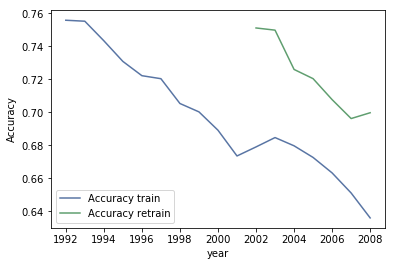

In [76] used -10613.6328 MiB RAM in 0.47s, total RAM usage 72308.20 MiB


In [76]:
# Airline Retrain Results
ax = plot_metrics(accuracy_series.to_dict(), accuracy_retrain.to_dict(), legend1='Accuracy train', 
                  legend2='Accuracy retrain', x_label='year', y_label='Accuracy')
fig = ax.get_figure()
fig.savefig('airline.svg', bbox_inches='tight')

As it can be seen, the performance is better after retraining. We have found concept drift in this dataset.